In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Exploratory Data Analysis (EDA)

In [2]:
df = pd.read_csv('../datasets/financial_fraud_feature_engineer.csv')

In [3]:
print(df.columns.to_list())

['transaction_id', 'timestamp', 'sender_account', 'receiver_account', 'amount', 'transaction_type', 'merchant_category', 'location', 'device_used', 'is_fraud', 'fraud_type', 'time_since_last_transaction', 'spending_deviation_score', 'velocity_score', 'geo_anomaly_score', 'payment_channel', 'ip_address', 'device_hash', 'transaction_hour', 'transaction_day_of_week', 'transaction_month', 'is_weekend', 'hour_sin', 'hour_cos', 'is_first_sender_receiver_tx', 'time_of_day', 'sender_1h_transaction_count', 'sender_24h_transaction_count', 'sender_7d_transaction_count', 'sender_24h_avg_amount', 'account_24h_sum_amount', 'account_24h_max_amount', 'account_24h_std_amount', 'receiver_24h_transaction_count', 'receiver_24h_unique_senders', 'receiver_24h_sum_amount', 'receiver_24h_max_amount', 'device_account_count_24h', 'account_device_count_24h', 'sender_24h_unique_receivers', 'ip_24h_transaction_count', 'subnet_24h_transaction_count', 'subnet_24h_unique_accounts', 'receiver_unique_sender_devices', '

In [4]:
# Define split points
n = len(df)
train_end = int(n * 0.7)
validation_end = int(n * 0.85)

# Create the splits
train_df = df.iloc[:train_end]
validation_df = df.iloc[train_end:validation_end]
test_df = df.iloc[validation_end:]

print(f"Training set shape: {train_df.shape}")
print(f"Validation set shape: {validation_df.shape}")
print(f"Test set shape: {test_df.shape}")

Training set shape: (3500000, 103)
Validation set shape: (750000, 103)
Test set shape: (750000, 103)


In [8]:
TARGET = 'is_fraud'

# Drop identifiers, the target, and related/raw columns
features_to_drop = [
    'transaction_id', 'timestamp', 'sender_account', 'receiver_account',
    'ip_address', 'device_hash', 'fraud_type', 'is_fraud'
]

X_train = train_df.drop(columns=features_to_drop)
y_train = train_df[TARGET]

X_validation = validation_df.drop(columns=features_to_drop)
y_validation = validation_df[TARGET]

X_test = test_df.drop(columns=features_to_drop)
y_test = test_df[TARGET]

# Identify and convert categorical features
categorical_features = [
    'transaction_type', 'merchant_category', 'location', 'device_used',
    'payment_channel', 'time_of_day', 'type_device_interaction',
    'channel_merchant_interaction'
]

for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_validation[col] = X_validation[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [ ]:
numerical_X_train = X_train.select_dtypes(include=np.number)

print(f"Calculating correlation on {len(numerical_X_train.columns)} numerical features...")
correlation_matrix = numerical_X_train.corr()

print("Correlation matrix calculated.")

In [17]:
correlation_matrix

,amount,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,transaction_hour,transaction_day_of_week,transaction_month,is_weekend,hour_sin,...,amount_deviation_from_account_avg,account_merchant_avg_spend,amount_vs_account_merchant_avg,sender_receiver_device_same,is_shared_device_receiver,type_device_interaction_freq_encoded,channel_merchant_interaction_freq_encoded,location_freq_encoded,merchant_category_freq_encoded,ip_subnet_freq_encoded
amount,1.000000,0.000121,0.001198,-0.001042,0.000370,-0.000704,-0.000311,0.000591,0.000049,0.000796,...,-0.000643,-0.000150,0.050803,NaN,-0.000522,0.065371,-0.000164,0.001501,-0.000156,-0.000301
time_since_last_transaction,0.000121,1.000000,-0.000253,0.000996,-0.000074,0.001342,-0.000260,0.569915,0.000573,-0.000955,...,0.231491,0.128281,0.014986,NaN,-0.000282,0.000208,-0.000587,-0.000053,-0.000722,-0.000657
spending_deviation_score,0.001198,-0.000253,1.000000,-0.000304,0.000615,-0.000747,-0.000659,-0.000278,-0.000283,0.000475,...,0.000114,0.000554,-0.000366,NaN,-0.001148,-0.000117,-0.000404,-0.000213,-0.000509,-0.000576
velocity_score,-0.001042,0.000996,-0.000304,1.000000,0.000235,0.000774,0.000696,0.000120,0.000247,-0.000800,...,0.000698,-0.000014,-0.000535,NaN,-0.000643,-0.000510,0.000746,0.000407,0.000207,-0.000421
geo_anomaly_score,0.000370,-0.000074,0.000615,0.000235,1.000000,-0.000637,0.000389,0.000053,0.000380,0.000095,...,0.000658,-0.000087,-0.000020,NaN,0.000074,0.000339,0.000005,-0.000248,-0.000781,0.001108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
type_device_interaction_freq_encoded,0.065371,0.000208,-0.000117,-0.000510,0.000339,-0.000472,0.000537,0.000235,-0.000050,0.000440,...,0.000348,0.000085,0.003081,NaN,-0.000103,1.000000,0.000455,-0.000068,0.000587,0.000519
channel_merchant_interaction_freq_encoded,-0.000164,-0.000587,-0.000404,0.000746,0.000005,-0.000499,0.000408,-0.000797,0.000005,0.000308,...,0.000883,0.000319,-0.000126,NaN,0.000591,0.000455,1.000000,0.000244,0.569977,0.000163
location_freq_encoded,0.001501,-0.000053,-0.000213,0.000407,-0.000248,0.000683,0.000235,-0.000283,0.000158,-0.000271,...,-0.000044,-0.000009,0.000115,NaN,0.000150,-0.000068,0.000244,1.000000,0.000454,-0.000888
merchant_category_freq_encoded,-0.000156,-0.000722,-0.000509,0.000207,-0.000781,-0.000824,0.000334,-0.000378,0.000127,0.000488,...,0.000385,0.001447,0.000607,NaN,0.000186,0.000587,0.569977,0.000454,1.000000,-0.000215


In [27]:
# Boolean mask for the upper triangle of the matrix
upper_triangle_mask = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
upper_triangle = correlation_matrix.where(upper_triangle_mask)

# Features with a correlation greater than 0.95
threshold = 0.95
highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column].abs() > threshold)]

print(f"Found {len(highly_correlated_features)} features to drop with a threshold of {threshold}:")
print(highly_correlated_features)

# Print all pairs of features with high correlation and their correlation value
correlated_pairs = upper_triangle[upper_triangle.abs() > threshold].stack().reset_index()
correlated_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
print("\nHighly correlated feature pairs (correlation > threshold):")
for _, row in correlated_pairs.iterrows():
    print(f"{row['Feature 1']} <-> {row['Feature 2']}: {row['Correlation']:.4f}")

Found 17 features to drop with a threshold of 0.95:
['account_24h_sum_amount', 'account_24h_max_amount', 'receiver_24h_unique_senders', 'receiver_24h_max_amount', 'account_device_count_24h', 'sender_24h_unique_receivers', 'subnet_24h_unique_accounts', 'fan_in_ratio_24h', 'sender_receiver_tx_count', 'amount_merchant_z_score', 'sender_new_receiver_count_24h', 'velocity_change_1h_vs_24h', 'amount_to_merchant_avg_ratio', 'amount_deviation_from_merchant_avg', 'hour_deviation_from_avg', 'sender_1h_sum_amount', 'amount_deviation_from_account_avg']

Highly correlated feature pairs (correlation > threshold):
amount <-> amount_merchant_z_score: 0.9997
amount <-> amount_to_merchant_avg_ratio: 0.9999
is_first_sender_receiver_tx <-> sender_receiver_tx_count: -1.0000
sender_24h_transaction_count <-> account_device_count_24h: 1.0000
sender_24h_transaction_count <-> sender_24h_unique_receivers: 1.0000
sender_24h_transaction_count <-> sender_new_receiver_count_24h: 0.9999
sender_24h_transaction_count <

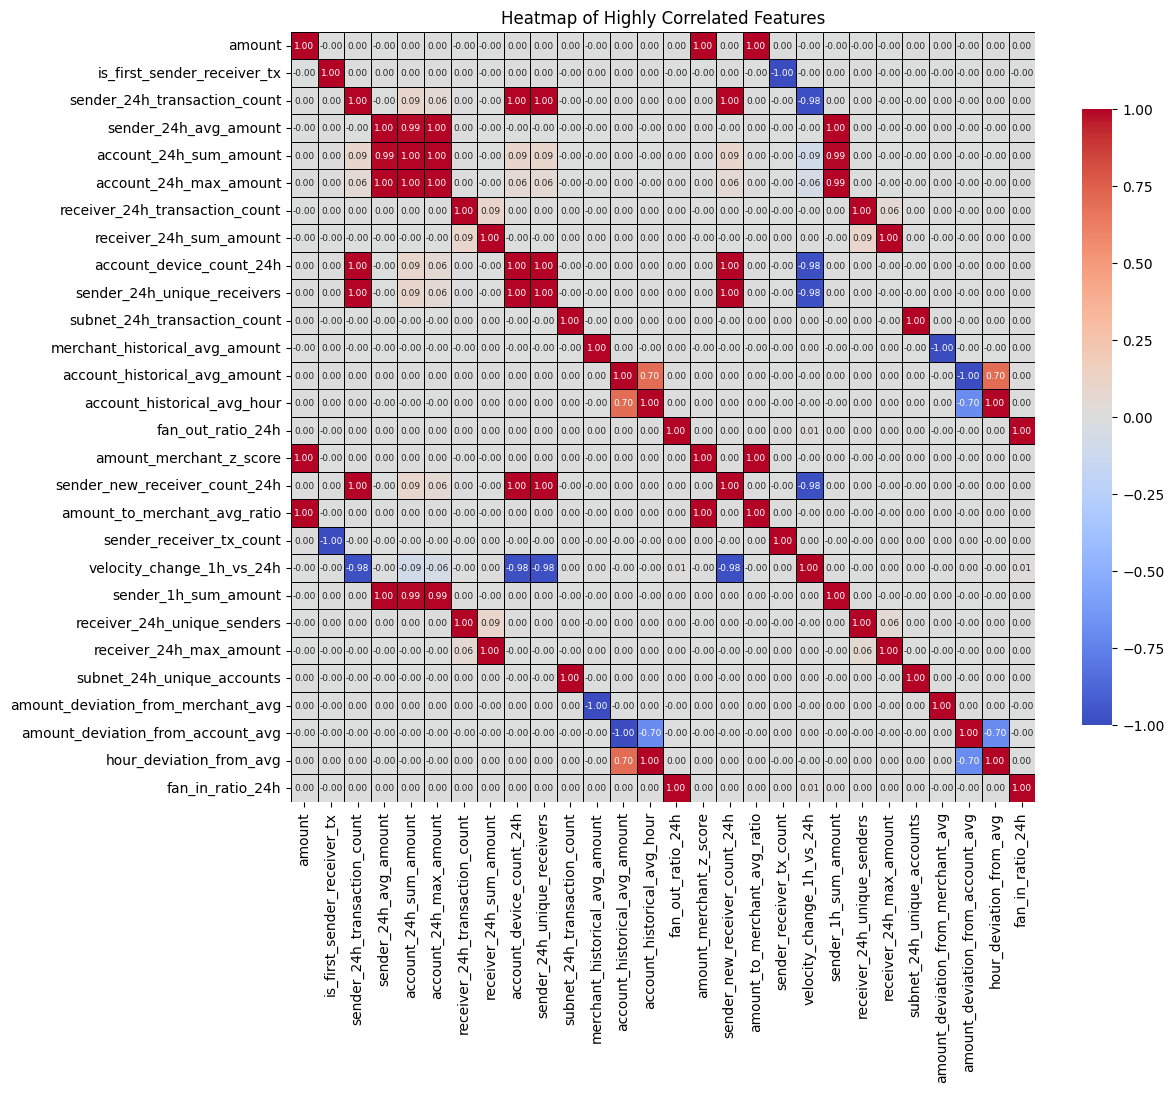

In [23]:
# Find all pairs that are highly correlated to build a targeted heatmap
# This gives more context than just the list of columns to drop
correlated_pairs = upper_triangle[upper_triangle.abs() > threshold].stack().reset_index()
correlated_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']

# Get a unique list of all features involved in high correlation pairs
features_to_plot = pd.unique(correlated_pairs[['Feature 1', 'Feature 2']].values.ravel('K'))

# Create a heatmap for only these specific features
plt.figure(figsize=(12, 10))
sns.heatmap(
    X_train[features_to_plot].corr(),
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    annot_kws={"size": 6.5},
    linewidths=0.7,
    linecolor='black',
    cbar_kws={"shrink": 0.8}
)
plt.title('Heatmap of Highly Correlated Features')
plt.show()

In [28]:
# List of columns to drop based on contextual analysis
features_to_drop_contextual = [
    'amount_merchant_z_score',
    'amount_to_merchant_avg_ratio',
    'is_first_sender_receiver_tx',
    'account_device_count_24h',
    'sender_24h_unique_receivers',
    'sender_new_receiver_count_24h',
    'sender_24h_avg_amount',
    'account_24h_max_amount',
    'sender_1h_sum_amount',
    'receiver_24h_unique_senders',
    'receiver_24h_max_amount',
    'subnet_24h_unique_accounts',
    'account_historical_avg_amount',
    'merchant_historical_avg_amount',
    'account_historical_avg_hour',
    'fan_in_ratio_24h',
    'velocity_change_1h_vs_24h'
]

# Apply the removal to data splits
X_train_reduced = X_train.drop(columns=features_to_drop_contextual)
X_validation_reduced = X_validation.drop(columns=features_to_drop_contextual)
X_test_reduced = X_test.drop(columns=features_to_drop_contextual)

print(f"\nOriginal number of features: {X_train.shape[1]}")
print(f"Reduced number of features: {X_train_reduced.shape[1]}")


Original number of features: 95
Reduced number of features: 78


Fraud distribution in the training set:
is_fraud
False    96.415629
True      3.584371
Name: proportion, dtype: float64


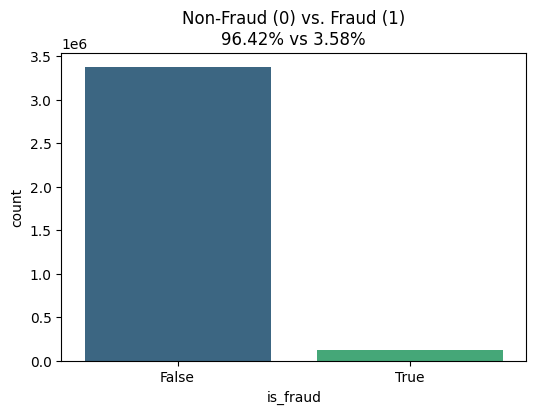

In [30]:
# Use the original train_df to see the distribution
fraud_percentage = train_df[TARGET].value_counts(normalize=True) * 100
print("Fraud distribution in the training set:")
print(fraud_percentage)

plt.figure(figsize=(6, 4))
sns.countplot(x=TARGET, data=train_df, hue=TARGET, palette='viridis', legend=False)
plt.title(f'Non-Fraud (0) vs. Fraud (1)\n{fraud_percentage.iloc[0]:.2f}% vs {fraud_percentage.iloc[1]:.2f}%')
plt.show()

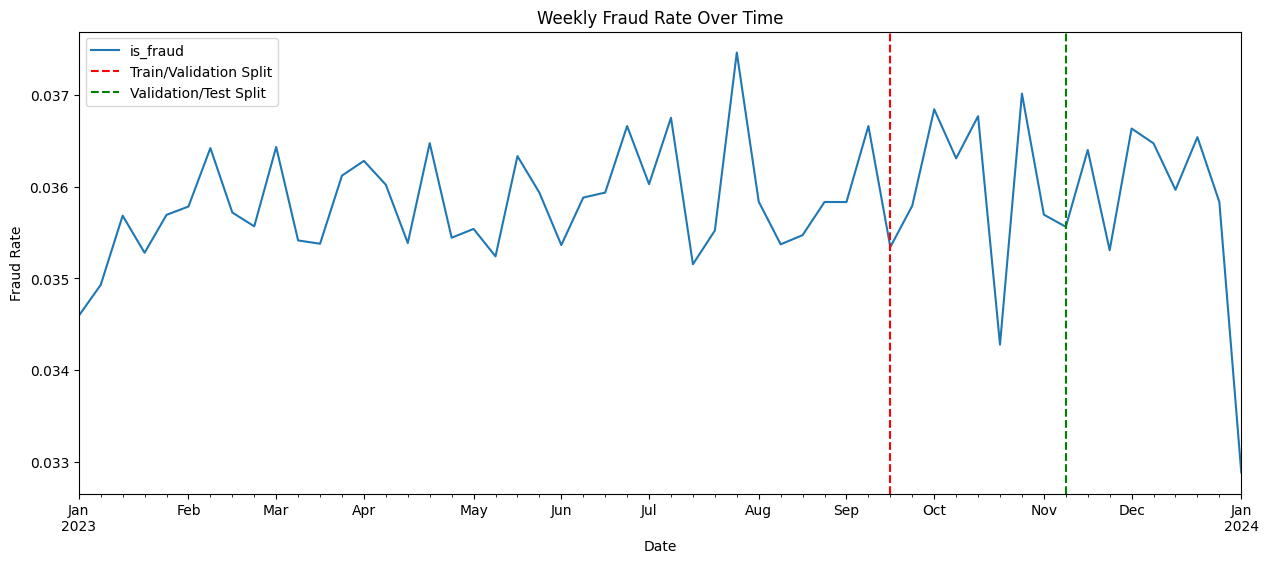

In [33]:
# Use original df which has the timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Resample by week and calculate the fraud rate
weekly_fraud_rate = df.set_index('timestamp')['is_fraud'].resample('W').mean()

plt.figure(figsize=(15, 6))
weekly_fraud_rate.plot()
plt.title('Weekly Fraud Rate Over Time')
plt.ylabel('Fraud Rate')
plt.xlabel('Date')
# Add vertical lines for train/validation/test splits
plt.axvline(train_df['timestamp'].iloc[-1], color='red', linestyle='--', label='Train/Validation Split')
plt.axvline(validation_df['timestamp'].iloc[-1], color='green', linestyle='--', label='Validation/Test Split')
plt.legend()
plt.show()